In [1]:
import pandas as pd
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.callbacks import LearningRateScheduler
from tabulate import tabulate
from src import camvid
from src import evaluate
from src import predict
from src import predict_video
from src import enet
from src.callbacks import PlotMetrics
from src.utils import history_to_results
%matplotlib inline

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/usr/local/Cellar/python/3.6.4_3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
weights_file = 'models/ENet-CamVid11.h5'

In [3]:
# the batch size for training
batch_size = 8
# the size to crop images to
crop_size = (352, 480)

# Training

In [4]:
camvid11 = camvid.CamVid(
    mapping=camvid.load_mapping(), 
    target_size=(360, 480), 
    crop_size=crop_size, 
    batch_size=batch_size, 
    ignored_labels=['Void'],
)
generators = camvid11.generators()

Found 367 images belonging to 1 classes.
Found 367 images belonging to 1 classes.
Found 101 images belonging to 1 classes.
Found 101 images belonging to 1 classes.
Found 233 images belonging to 1 classes.
Found 233 images belonging to 1 classes.


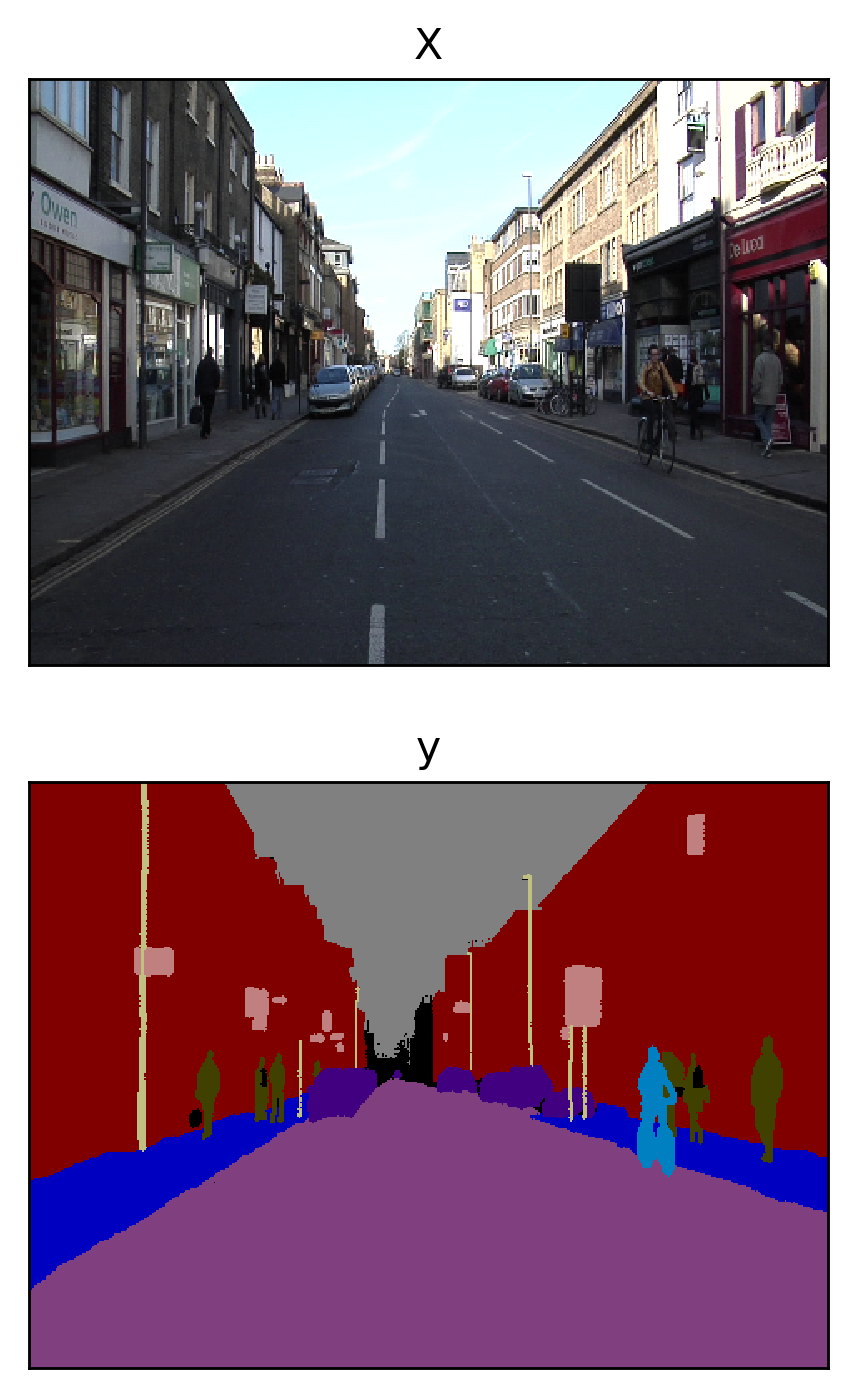

In [5]:
# get the next X, y training tuple
X, y = next(generators['train'])
# transform the onehot vector to an image
y = camvid11.unmap(y)
# plot the images
_ = camvid.plot(X=X[0], y=y[0], order=['X', 'y'])

In [6]:
# build the model for the image shape and number of labels
model = enet.enet((*crop_size, 3), camvid11.n, camvid11.class_weights)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 352, 480, 3)  0                                            
__________________________________________________________________________________________________
pixel_norm (Lambda)             (None, 352, 480, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 176, 240, 13) 364         pixel_norm[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 176, 240, 3)  0           pixel_norm[0][0]                 
__________________________________________________________________________________________________
concatenat

In [ ]:
# create the callbacks for the training procedure
callbacks = [
    EarlyStopping(monitor='loss', patience=10),
    LearningRateScheduler(lambda _, lr: 0.95 * lr),
    ModelCheckpoint(weights_file, 
        monitor='val_categorical_accuracy', 
        save_best_only=True, 
        save_weights_only=True, 
        mode='max',
    ),
    PlotMetrics(),
]

In [ ]:
# fit the model with the data. divide the steps per epoch by the 
# batch size (which is 3 in this case)
history = model.fit_generator(generators['train'],
    epochs=100,
    steps_per_epoch=int(367 / batch_size),
    validation_data=generators['val'],
    validation_steps=101,
    callbacks=callbacks,
    verbose=0
)

In [ ]:
history_to_results(history)

## Load Best Model

In [ ]:
model.load_weights(weights_file)

# Test Metrics

In [ ]:
metrics = evaluate.evaluate(model, generators['test'], 233,
    mask=camvid11.class_mask, 
    label_map=camvid11.label_to_discrete_map
)
metrics.to_csv(weights_file + '.csv')
metrics

In [ ]:
print(tabulate(metrics, tablefmt='pipe', headers=('Metric', 'Value')))

# Qualitative Results

### Train

In [ ]:
X, y, p = predict.predict(model, generators['train'], camvid11)

In [ ]:
_ = camvid.plot(X=X[0], y=y[0], y_pred=p[0], order=['X', 'y', 'y_pred'])

In [ ]:
_ = camvid.plot(X=X[1], y=y[1], y_pred=p[1], order=['X', 'y', 'y_pred'])

In [ ]:
_ = camvid.plot(X=X[2], y=y[2], y_pred=p[2], order=['X', 'y', 'y_pred'])

In [ ]:
_ = camvid.plot(X=X[3], y=y[3], y_pred=p[3], order=['X', 'y', 'y_pred'])

### Validation

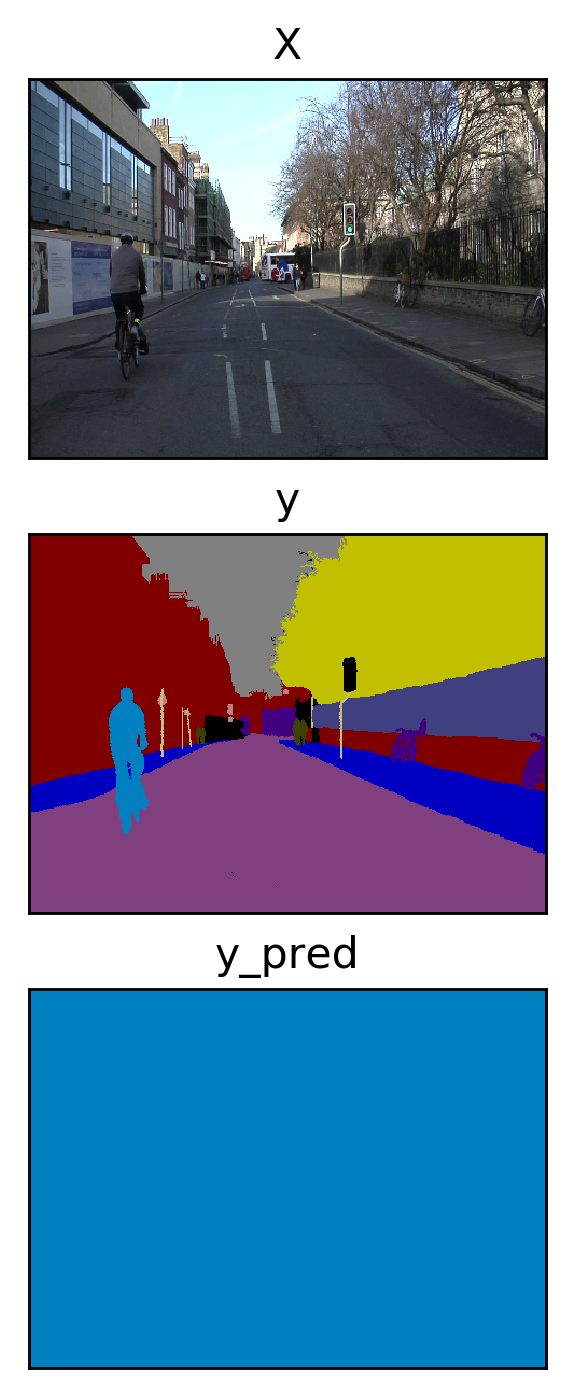

In [8]:
X, y, p = predict.predict(model, generators['val'], camvid11)
_ = camvid.plot(X=X[0], y=y[0], y_pred=p[0], order=['X', 'y', 'y_pred'])

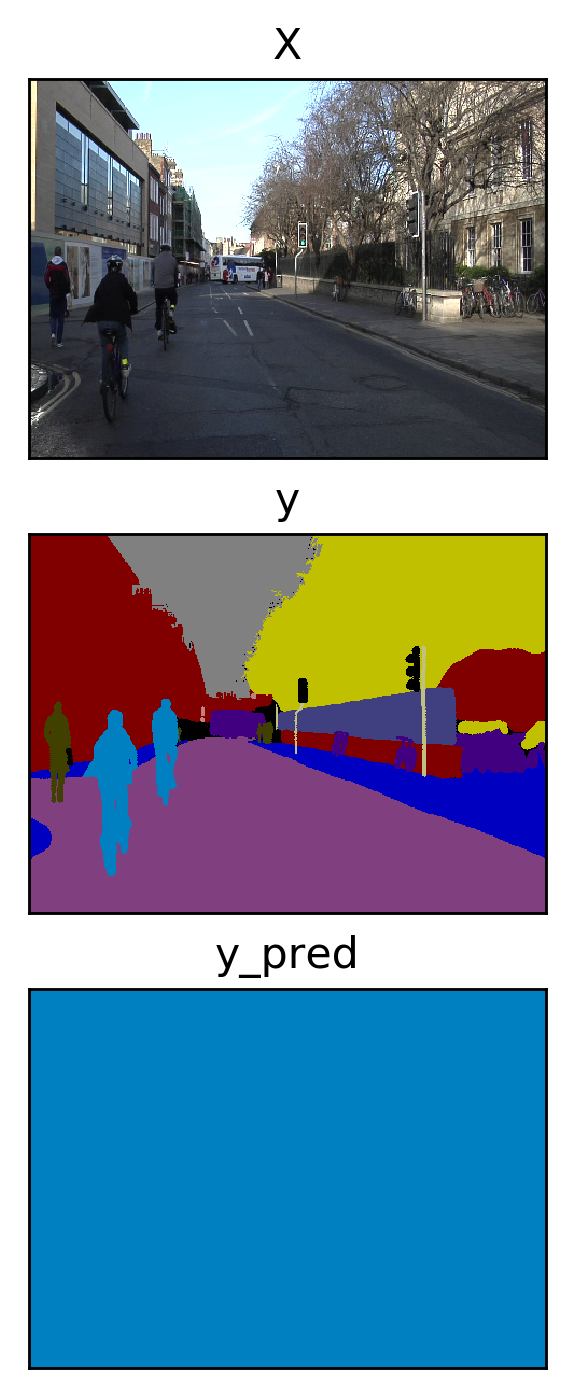

In [9]:
X, y, p = predict.predict(model, generators['val'], camvid11)
_ = camvid.plot(X=X[0], y=y[0], y_pred=p[0], order=['X', 'y', 'y_pred'])

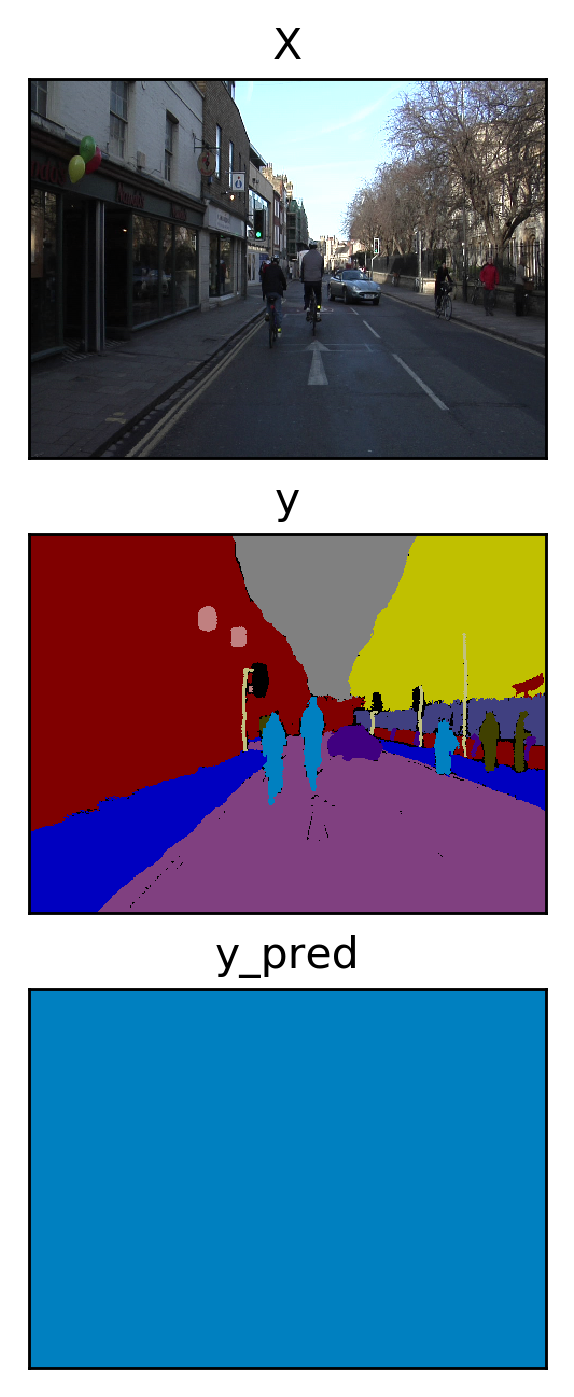

In [10]:
X, y, p = predict.predict(model, generators['val'], camvid11)
_ = camvid.plot(X=X[0], y=y[0], y_pred=p[0], order=['X', 'y', 'y_pred'])

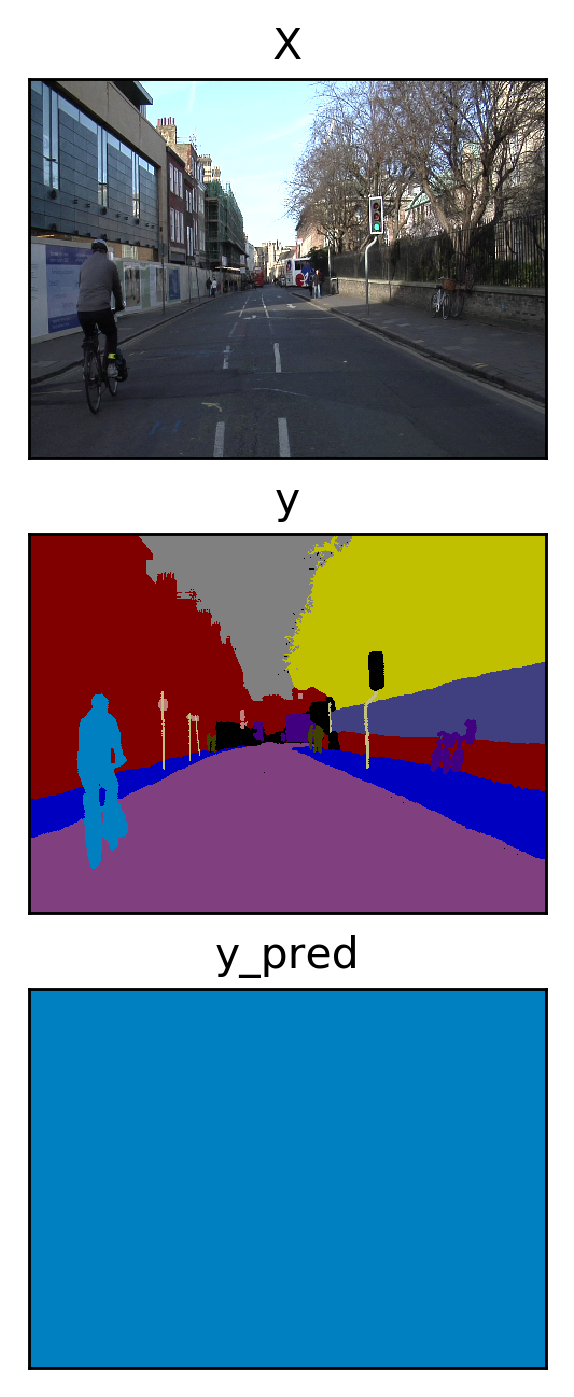

In [11]:
X, y, p = predict.predict(model, generators['val'], camvid11)
_ = camvid.plot(X=X[0], y=y[0], y_pred=p[0], order=['X', 'y', 'y_pred'])

### Test

In [ ]:
X, y, p = predict.predict(model, generators['test'], camvid11)
fig = camvid.plot(X=X[0], y=y[0], y_pred=p[0], order=['X', 'y', 'y_pred'])
fig.savefig('img/segnet/0.png', transparent=True, bbox_inches='tight')

In [ ]:
X, y, p = predict.predict(model, generators['test'], camvid11)
fig = camvid.plot(X=X[0], y=y[0], y_pred=p[0], order=['X', 'y', 'y_pred'])
fig.savefig('img/segnet/1.png', transparent=True, bbox_inches='tight')

In [ ]:
X, y, p = predict.predict(model, generators['test'], camvid11)
fig = camvid.plot(X=X[0], y=y[0], y_pred=p[0], order=['X', 'y', 'y_pred'])
fig.savefig('img/segnet/2.png', transparent=True, bbox_inches='tight')

In [ ]:
X, y, p = predict.predict(model, generators['test'], camvid11)
fig = camvid.plot(X=X[0], y=y[0], y_pred=p[0], order=['X', 'y', 'y_pred'])
fig.savefig('img/segnet/3.png', transparent=True, bbox_inches='tight')

# Video

In [ ]:
video_file = '0005VD.mp4'
video_path = camvid.videos.abs_path(video_file)
out_path = 'img/segnet/{}'.format(video_file)

In [ ]:
predict_video.predict_video(video_path, out_path, camvid11, model, predict.predict)